In [1]:
# Check and install required libraries
!pip install pandas numpy scikit-learn xgboost lightgbm matplotlib seaborn tensorflow shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 3.9 MB/s eta 0:00:00


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/content/crop_price_data.csv')

# Check for missing values
df.isnull().sum()

# Handle missing values (if any)
df.fillna(method='ffill', inplace=True)

# Handle outliers using IQR (optional)
Q1 = df['Max_Price'].quantile(0.25)
Q3 = df['Max_Price'].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df['Max_Price'] < (Q1 - 1.5 * IQR)) | (df['Max_Price'] > (Q3 + 1.5 * IQR)))]

# Feature engineering: Create lag features (previous day prices)
df['Prev_Min_Price'] = df.groupby(['City', 'Crop'])['Min_Price'].shift(1)
df['Prev_Max_Price'] = df.groupby(['City', 'Crop'])['Max_Price'].shift(1)

# Rolling averages
# df['Rolling_Min_Price_3'] = df.groupby(['City', 'Crop'])['Min_Price'].rolling(window=3).mean().reset_index(0, drop=True)
# df['Rolling_Max_Price_3'] = df.groupby(['City', 'Crop'])['Max_Price'].rolling(window=3).mean().reset_index(0, drop=True)
# Apply rolling averages properly within each group without index misalignment
# df['Rolling_Min_Price_3'] = df.groupby(['City', 'Crop'])['Min_Price'].apply(lambda x: x.rolling(window=3).mean())
# df['Rolling_Max_Price_3'] = df.groupby(['City', 'Crop'])['Max_Price'].apply(lambda x: x.rolling(window=3).mean())


<ipython-input-7-7aa26a09ee98>:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [10]:
# Group by 'City' and 'Crop', and apply rolling for Min_Price and Max_Price within each group
df['Rolling_Min_Price_3'] = df.groupby(['City', 'Crop'])['Min_Price'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df['Rolling_Max_Price_3'] = df.groupby(['City', 'Crop'])['Max_Price'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# Check if the columns are created
print(df.columns)  # Verify if 'Rolling_Min_Price_3' and 'Rolling_Max_Price_3' exist

# Display the first few rows to check the rolling columns
print(df[['City', 'Crop', 'Min_Price', 'Rolling_Min_Price_3', 'Max_Price', 'Rolling_Max_Price_3']].head())


Index(['Date', 'City', 'Crop', 'Min_Price', 'Max_Price', 'Season',
       'Prev_Min_Price', 'Prev_Max_Price', 'Rolling_Min_Price_3',
       'Rolling_Max_Price_3'],
      dtype='object')
   City    Crop  Min_Price  Rolling_Min_Price_3  Max_Price  \
0  Pune  Cotton    6890.66          6890.660000    6924.01   
1  Pune  Cotton    6804.15          6847.405000    6949.27   
2  Pune  Cotton    6722.64          6805.816667    6902.96   
3  Pune  Cotton    6756.04          6760.943333    7008.68   
4  Pune  Cotton    6707.34          6728.673333    7018.23   

   Rolling_Max_Price_3  
0          6924.010000  
1          6936.640000  
2          6925.413333  
3          6953.636667  
4          6976.623333  


In [11]:
le_city = LabelEncoder()
le_crop = LabelEncoder()
le_season = LabelEncoder()

df['City'] = le_city.fit_transform(df['City'])
df['Crop'] = le_crop.fit_transform(df['Crop'])
df['Season'] = le_season.fit_transform(df['Season'])

# Drop any remaining NaN values after feature creation
df.dropna(inplace=True)

# Feature and target separation
X = df.drop(columns=['Date', 'Min_Price', 'Max_Price'])
y = df['Max_Price']  # Predicting Max_Price as an example

# Normalize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "SVR": SVR(),
    "XGBoost": XGBRegressor(),
    "LightGBM": LGBMRegressor(),
    "Neural Network": MLPRegressor()
}

# Hyperparameter tuning using GridSearchCV (example for Random Forest)
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, 20], 'min_samples_split': [2, 5]}
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=TimeSeriesSplit(n_splits=5))
grid_rf.fit(X_train, y_train)

# Train and evaluate all models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results[name] = [mae, mse, rmse, r2]

# Display results
results_df = pd.DataFrame(results, index=['MAE', 'MSE', 'RMSE', 'R2'])
print(results_df.T)


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1038
[LightGBM] [Info] Number of data points in the train set: 13070, number of used features: 7
[LightGBM] [Info] Start training from score 3566.890657
                          MAE            MSE        RMSE        R2
Linear Regression   18.751097     715.052577   26.740467  0.999743
Random Forest       36.330949    3057.076681   55.290837  0.998903
SVR                657.412636  725814.027112  851.947197  0.739538
XGBoost            109.017532   55048.286725  234.623713  0.980246
LightGBM           109.854602   56118.781053  236.894029  0.979862
Neural Network      83.013326   12268.240213  110.762088  0.995597


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


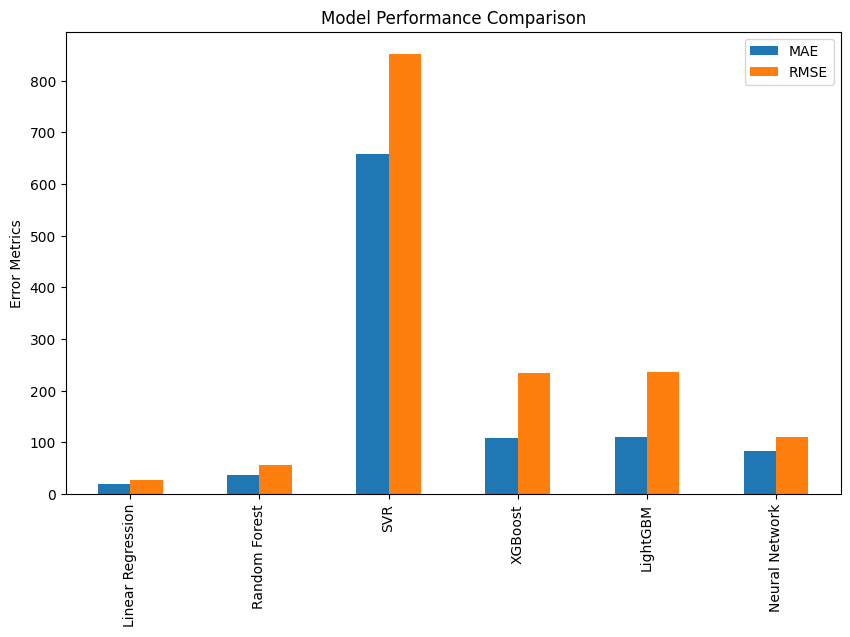

In [13]:
# Plot model comparison
results_df.T[['MAE', 'RMSE']].plot(kind='bar', figsize=(10, 6), title='Model Performance Comparison')
plt.ylabel('Error Metrics')
plt.show()


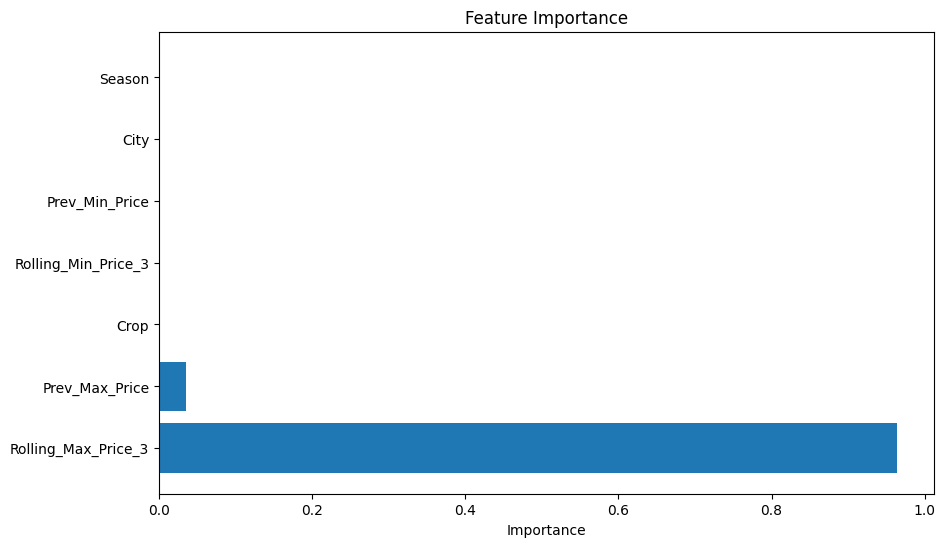

In [14]:
# Feature importance for Random Forest or XGBoost
importances = grid_rf.best_estimator_.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Importance')
plt.show()


In [15]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA model (fit on entire dataset as an example)
arima_model = ARIMA(y_train, order=(5,1,0))
arima_model_fit = arima_model.fit()
print(arima_model_fit.summary())

# Make predictions
arima_predictions = arima_model_fit.forecast(steps=len(y_test))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              Max_Price   No. Observations:                13070
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -85540.828
Date:                Sat, 21 Sep 2024   AIC                         171093.657
Time:                        19:27:38   BIC                         171138.525
Sample:                             0   HQIC                        171108.644
                              - 13070                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0013      0.023      0.055      0.956      -0.044       0.046
ar.L2          0.0100      0.017      0.589      0.556      -0.023       0.043
ar.L3          0.0047      0.022      0.214      0.8

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [16]:
from sklearn.ensemble import VotingRegressor

# Create an ensemble of RandomForest, XGBoost, and LightGBM
ensemble_model = VotingRegressor(estimators=[
    ('rf', RandomForestRegressor()),
    ('xgb', XGBRegressor()),
    ('lgb', LGBMRegressor())
])

# Fit and evaluate ensemble model
ensemble_model.fit(X_train, y_train)
ensemble_predictions = ensemble_model.predict(X_test)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_predictions))
print(f'Ensemble Model RMSE: {ensemble_rmse}')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1038
[LightGBM] [Info] Number of data points in the train set: 13070, number of used features: 7
[LightGBM] [Info] Start training from score 3566.890657
Ensemble Model RMSE: 163.84350002141701


In [17]:
from sklearn.ensemble import StackingRegressor

# Stacking models (example)
stacking_model = StackingRegressor(
    estimators=[
        ('rf', RandomForestRegressor()),
        ('svr', SVR()),
        ('xgb', XGBRegressor())
    ],
    final_estimator=LinearRegression()
)

# Fit and evaluate stacking model
stacking_model.fit(X_train, y_train)
stacking_predictions = stacking_model.predict(X_test)
stacking_rmse = np.sqrt(mean_squared_error(y_test, stacking_predictions))
print(f'Stacking Model RMSE: {stacking_rmse}')


Stacking Model RMSE: 123.97528154078584


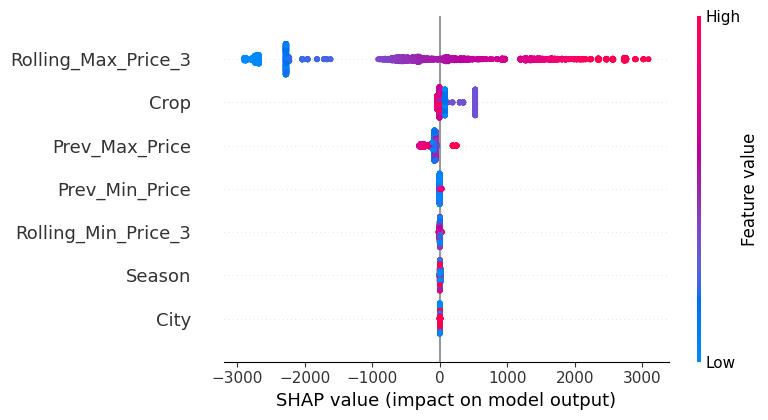

In [18]:
import shap

# Fit the SHAP explainer for XGBoost
explainer = shap.Explainer(models['XGBoost'])
shap_values = explainer(X_test)

# SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns)


In [19]:
import joblib

# Save the best performing model
best_model = models['Random Forest']  # Replace with your best model
joblib.dump(best_model, 'best_model.pkl')

# Load the model
loaded_model = joblib.load('best_model.pkl')

# Make predictions with the loaded model
new_predictions = loaded_model.predict(X_test)


In [21]:
import pandas as pd
from google.colab import files

# Assuming you already have the DataFrame `df` containing the dataset
# Example DataFrame creation if the dataset is already loaded
# df = pd.read_csv('path_to_your_dataset.csv')

# Save the dataset to a CSV file
df.to_csv('crop_price_data.csv', index=False)

# Provide a download link for the CSV file
files.download('crop_price_data.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
# Example feature preparation for the prediction
new_data = {
    'City': le_city.transform(['Pune'])[0],
    'Crop': le_crop.transform(['Cotton'])[0],
    'Season': le_season.transform(['Rainy'])[0],
    'Prev_Min_Price': 6600 ,  # Set based on historical values
    'Prev_Max_Price': 7000 ,  # Set based on historical values
    'Rolling_Min_Price_3': 6805 ,
    'Rolling_Max_Price_3': 6925 ,
    # Add any other features you engineered
}

new_data_df = pd.DataFrame([new_data])

# Scale the features
new_data_scaled = scaler.transform(new_data_df)

# Make prediction
predicted_price = best_model.predict(new_data_scaled)
print(f"Predicted price of cotton on 14-09-2024 in Pune: {predicted_price[0]}")


Predicted price of cotton on 14-09-2024 in Pune: 6897.700600000002
